# Vehicle Detection Project

## Goals

* [Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier](#hog)
* [Apply a color transform and append binned color features, as well as histograms of color](#color)
* [Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing]
* [Implement a sliding-window technique and use your trained classifier to search for vehicles in images](#sliding_window)
* [Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles](#video_pipeline)
* Estimate a bounding box for vehicles detected.(#bounding)

In [59]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from sklearn.utils import shuffle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import pandas as pd
import numpy as np
import pickle
import cv2
import glob
import time
import os

%matplotlib inline

In [2]:
import os
from glob import glob
import random

def get_images_filenames_in_directory(start_dir):
    files = []
    pattern   = "*.png"
    for dir,_,_ in os.walk(start_dir):
        files.extend(glob(os.path.join(dir,pattern)))
    return files

def get_vehicle_images():
    return get_images_filenames_in_directory('./vehicles')
    
def get_non_vehicle_images():
    return get_images_filenames_in_directory('./non-vehicles')

def get_image(filename):
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def get_image_in_cspace(img, color_space):
    feature_image = np.copy(img)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return feature_image

def get_gray_image(filename):
    return cv2.cvtColor(get_image(filename), cv2.COLOR_RGB2GRAY)

def display_image(filename, title):
    img = get_image(filename)
    plt.title(title)
    plt.imshow(img)


# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    
    test_image = get_image(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_image.shape 
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_image.dtype
    # Return data_dict
    
    return data_dict

car_list, notcar_list = get_vehicle_images(), get_non_vehicle_images()   
data_info = data_look(car_list, notcar_list)

print(data_info)

{'image_shape': (64, 64, 3), 'n_notcars': 8968, 'n_cars': 8792, 'data_type': dtype('uint8')}


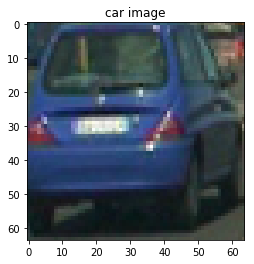

In [3]:
display_image(car_list[random.randint(0, data_info['n_cars'])], 'car image')

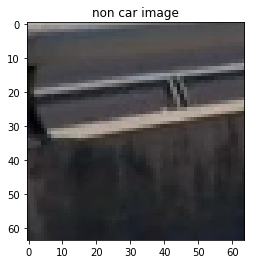

In [4]:
display_image(notcar_list[random.randint(0, data_info['n_notcars'])], 'non car image')

<h2><a href="hog">Histogram of Gradients</a></h2>

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

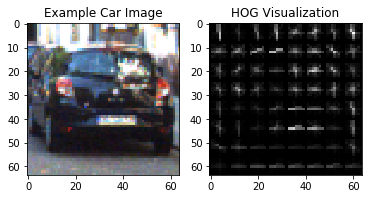

In [6]:
# Define HOG parameters
car_filename = car_list[random.randint(0, data_info['n_cars'])]
car_image = get_image(car_filename)
car_image_gray = get_gray_image(car_filename)

orient = 12
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(car_image_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

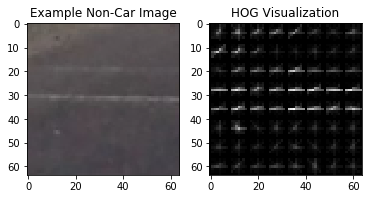

In [7]:
notcar_filename = notcar_list[random.randint(0, data_info['n_notcars'])]
notcar_image = get_image(notcar_filename)
notcar_image_gray = get_gray_image(notcar_filename)
features, hog_image = get_hog_features(notcar_image_gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(notcar_image, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

It is clear from the HOG visualization images that there are vast differences between car and non-car gradients. One noticible aspect is that car gradients are visualized as horizontal lines at the bottom and vertical lines at the top of the image  

## Color Histogram

In [8]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0],nbins, bins_range)
    ghist = np.histogram(img[:,:,1],nbins, bins_range)
    bhist = np.histogram(img[:,:,2],nbins, bins_range)
    
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

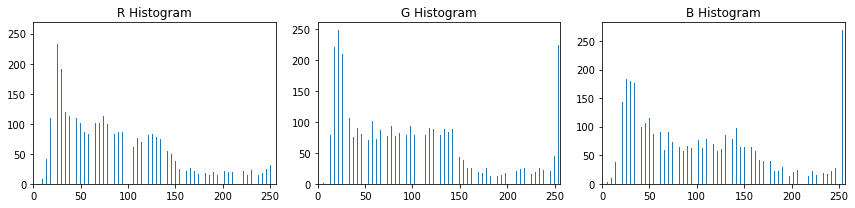

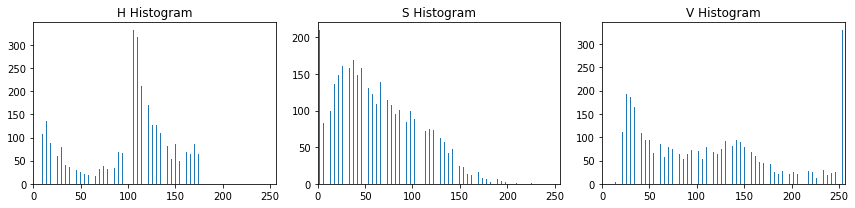

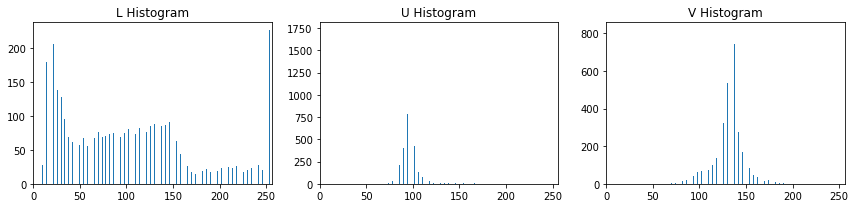

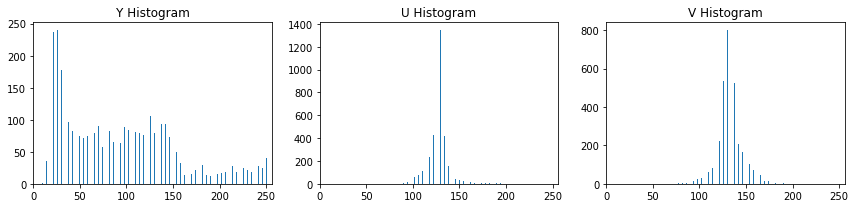

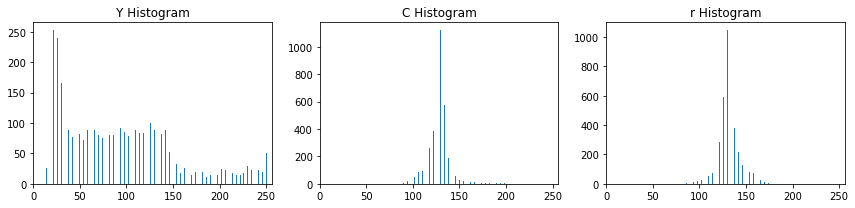

In [9]:
for idx, cspace in enumerate(['RGB', 'HSV', 'LUV','YUV', 'YCrCb']):
    rh, gh, bh, bincen, feature_vec = color_hist(
        get_image_in_cspace(car_image, cspace) , nbins=64, bins_range=(0, 256))
    

    # Plot a figure with all three bar charts
    if rh is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bincen, rh[0])
        plt.xlim(0, 256)
        plt.title(cspace[0]+' Histogram')
        plt.subplot(132)
        plt.bar(bincen, gh[0])
        plt.xlim(0, 256)
        plt.title(cspace[1]+' Histogram')
        plt.subplot(133)
        plt.bar(bincen, bh[0])
        plt.xlim(0, 256)
        plt.title(cspace[2]+' Histogram')
        
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')

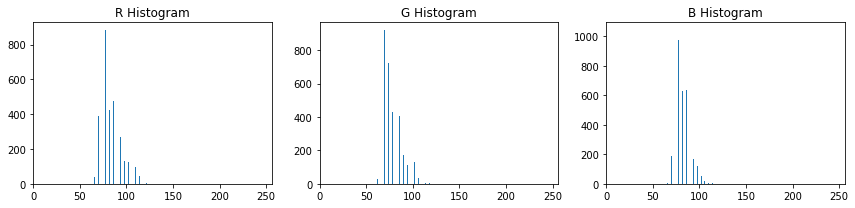

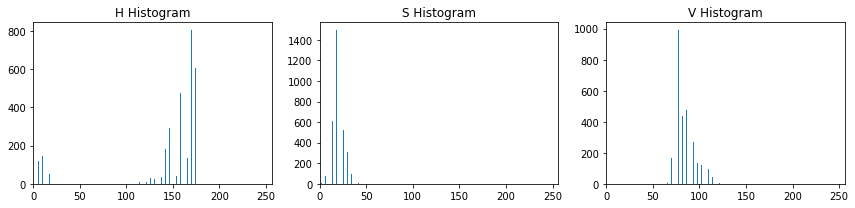

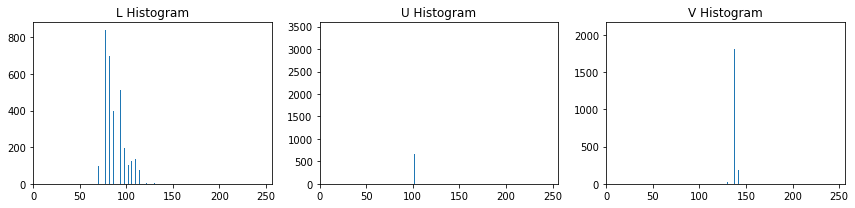

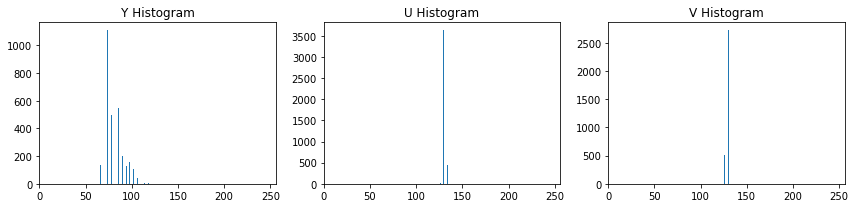

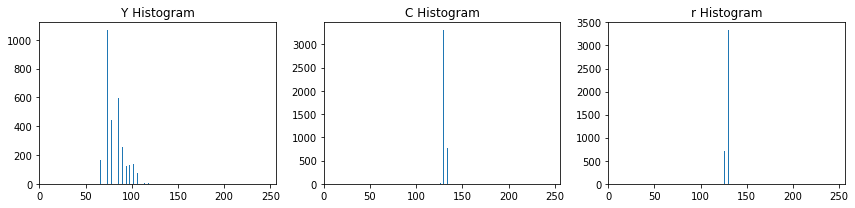

In [10]:
for idx, cspace in enumerate(['RGB', 'HSV', 'LUV','YUV', 'YCrCb']):
    rh, gh, bh, bincen, feature_vec = color_hist(
        get_image_in_cspace(notcar_image, cspace) , nbins=64, bins_range=(0, 256))
    

    # Plot a figure with all three bar charts
    if rh is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bincen, rh[0])
        plt.xlim(0, 256)
        plt.title(cspace[0]+' Histogram')
        plt.subplot(132)
        plt.bar(bincen, gh[0])
        plt.xlim(0, 256)
        plt.title(cspace[1]+' Histogram')
        plt.subplot(133)
        plt.bar(bincen, bh[0])
        plt.xlim(0, 256)
        plt.title(cspace[2]+' Histogram')
        
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')

Using Color Bins in the RGB colorspace can be considered a relevant feature for our classifier as the "RGB" color channel exhibits max difference for Car vs Non Car Images 

## Spatial Binning

In [11]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    
    feature_image = get_image_in_cspace(img, color_space)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel()
    
    #features = cv2.resize().ravel()
    # Return the feature vector
    return features

CAR IMAGE


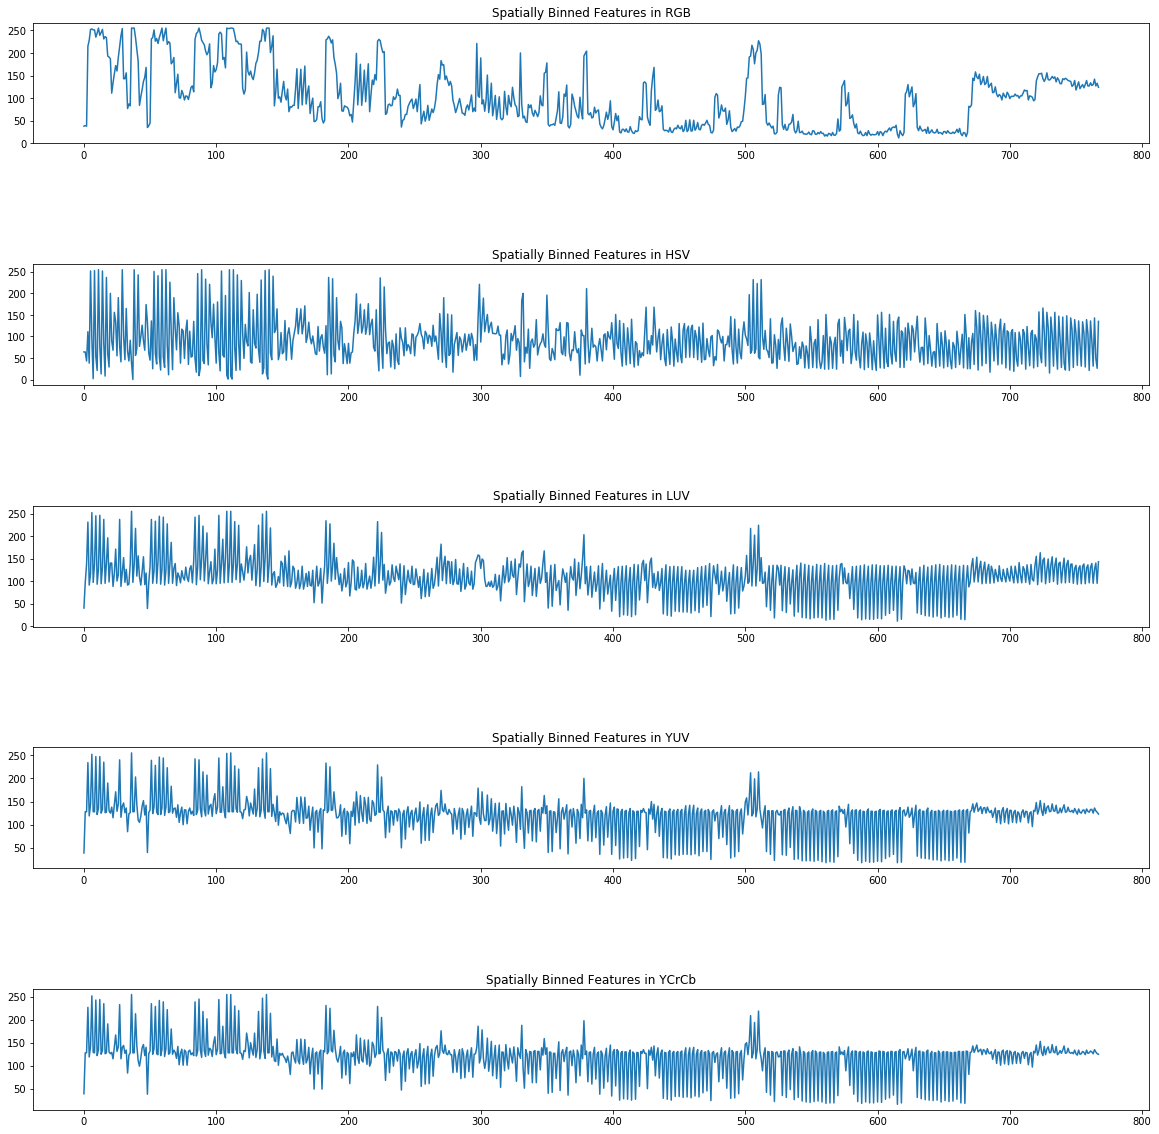

In [12]:
print("CAR IMAGE")
fig, axs = plt.subplots(figsize=(20, 20), nrows=5, ncols=1)
axs = axs.ravel()

for idx, cspace in enumerate(['RGB', 'HSV', 'LUV','YUV', 'YCrCb']):
    feature_vec = bin_spatial(car_image, color_space=cspace, size=(16, 16))
    axs[idx].plot(feature_vec)
    axs[idx].set_title('Spatially Binned Features in '+ cspace)
    
#fig.tight_layout()
fig.subplots_adjust(wspace=1.0, hspace=1.0)
plt.show()

NON CAR IMAGE


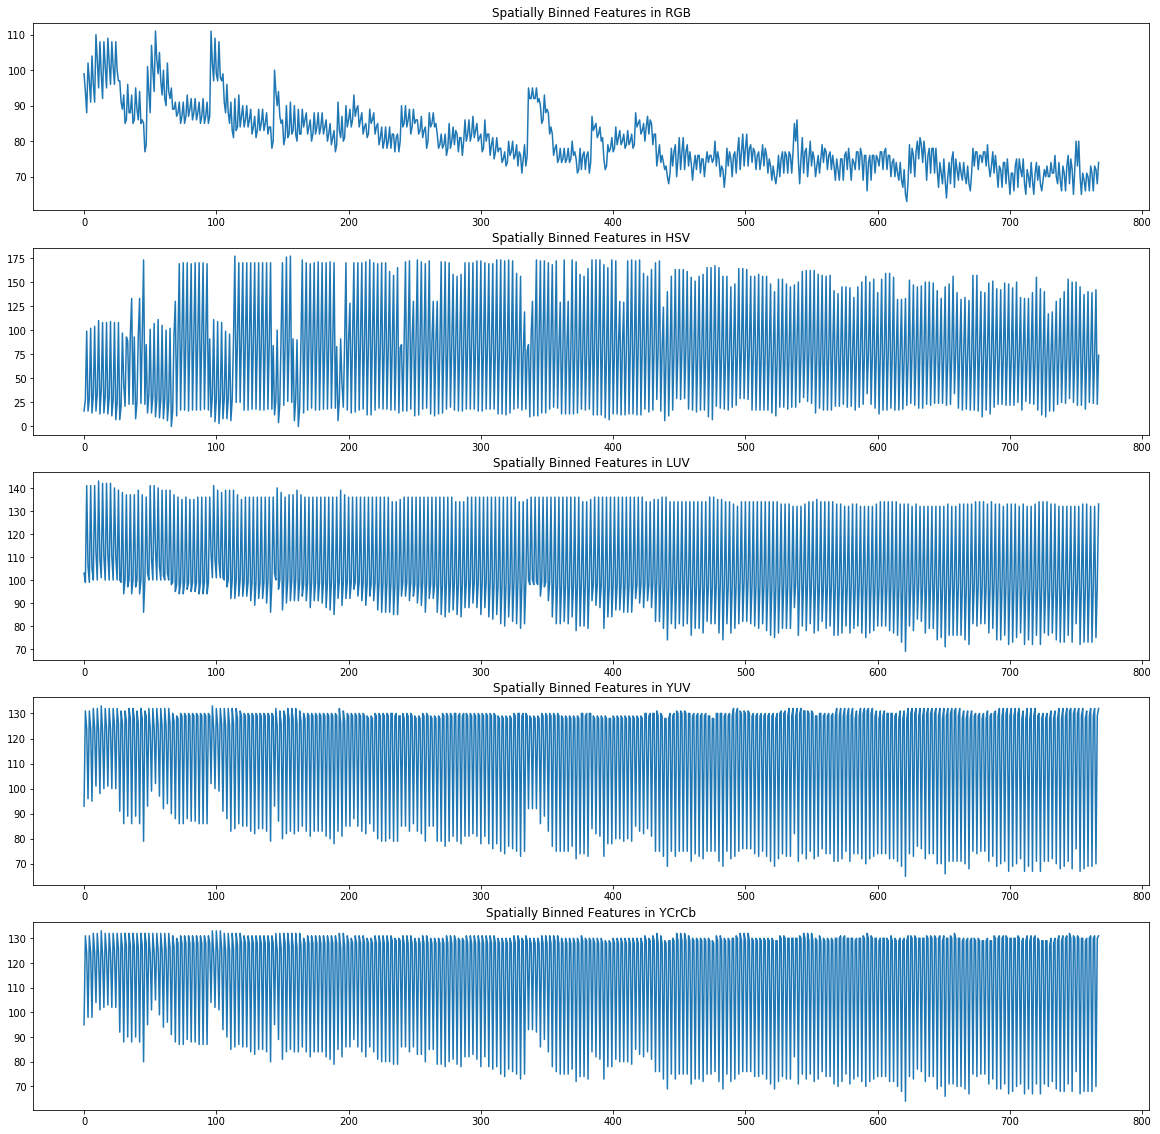

In [13]:
print("NON CAR IMAGE")
fig, axs = plt.subplots(figsize=(20, 20), nrows=5, ncols=1)
axs = axs.ravel()
for idx, cspace in enumerate(['RGB', 'HSV', 'LUV','YUV', 'YCrCb']):
    feature_vec = bin_spatial(notcar_image, color_space=cspace, size=(16, 16))
    axs[idx].plot(feature_vec)
    axs[idx].set_title('Spatially Binned Features in '+ cspace)

Spatial binning may serve as a better feature than color binning as here it is very easily observable that the RGB features are different for car vs non-car images

## Combine and Normalize Features

In [14]:
'''
Combine and Normalize Features For Color Space and Spatial Binning
'''

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        feature_image = get_image_in_cspace(get_image(file), cspace)
        spatial_features = bin_spatial(feature_image, color_space=cspace, size=spatial_size)
        #print("Spatial Features", spatial_features, spatial_features.shape)
        
        # Apply color_hist() also with a color space option now
        _, _, _, _, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        #print("Hist Features", hist_features, hist_features.shape)
            
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
        
    # Return list of feature vectors
    print("Shape", np.array(features).shape)
    return features


car_features_colors = extract_features(car_list, cspace='RGB', spatial_size=(16, 16),
                        hist_bins=32, hist_range=(0, 256))
notcar_features_colors = extract_features(notcar_list, cspace='RGB', spatial_size=(16, 16),
                        hist_bins=32, hist_range=(0, 256))

Shape (8792, 864)
Shape (8968, 864)


In [15]:
def display_features(car_features, notcar_features):
    if len(car_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        
        car_ind = np.random.randint(0, len(car_list))
        notcar_ind = np.random.randint(0, len(notcar_list))
        
        # Plot an example of raw and scaled features
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(get_image(car_list[car_ind]))
        plt.title('Original Car Image')
        plt.subplot(132)
        plt.plot(X[car_ind])
        plt.title('Raw Features')
        plt.subplot(133)
        plt.plot(scaled_X[car_ind])
        plt.title('Normalized Features')
        fig.tight_layout()
        
        
        fig = plt.figure(figsize=(12,4))
        plt.subplot(141)
        plt.imshow(get_image(notcar_list[notcar_ind]))
        plt.title('Original Non Car Image')
        plt.subplot(142)
        plt.plot(X[len(car_list) + notcar_ind])
        plt.title('Raw Features')
        plt.subplot(143)
        plt.plot(scaled_X[len(car_list) + notcar_ind])
        plt.title('Normalized Features')
        fig.tight_layout()
    else: 
        print('Your function only returns empty feature vectors...')

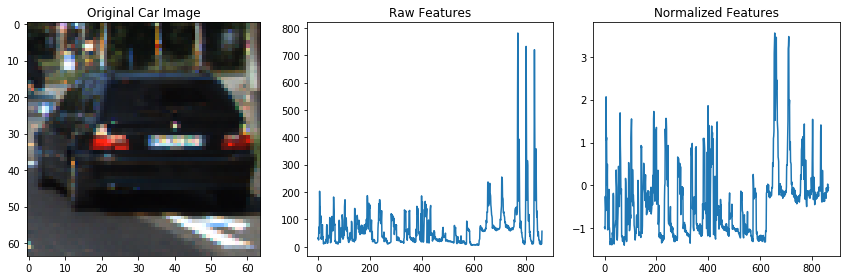

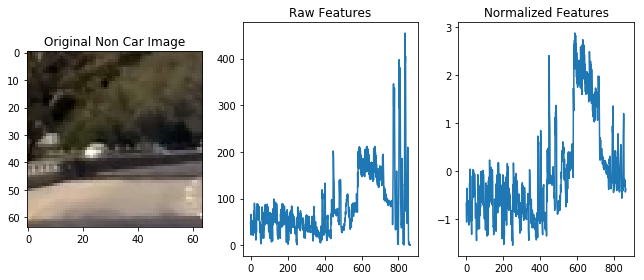

In [16]:
display_features(car_features_colors, notcar_features_colors)

In [17]:
'''
Combine and Normalize Features For HOG 
'''
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = get_image_in_cspace(get_image(file), cspace)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    return features



car_features_HOG = extract_features(car_list, cspace='YUV', orient=12, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')
notcar_features_HOG = extract_features(notcar_list, cspace='YUV', orient=12, pix_per_cell=8, cell_per_block=2, hog_channel='ALL')

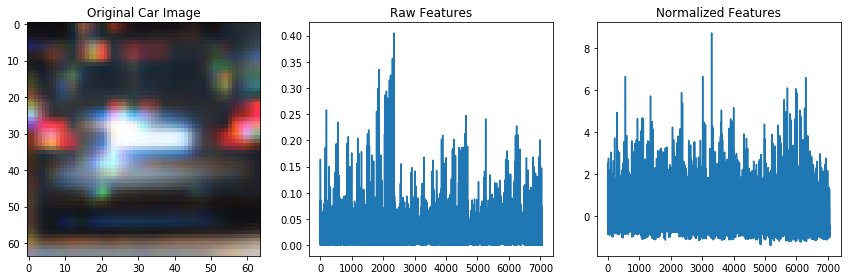

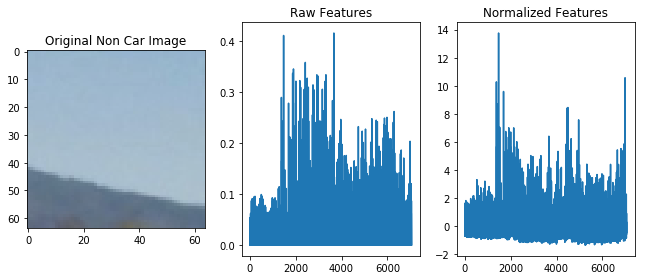

In [18]:
display_features(car_features_HOG, notcar_features_HOG)

In [79]:
# Feature extraction parameters
def feature_testing(car_features, notcar_features):
    X = np.vstack((car_features, notcar_features)).astype(np.float64)  
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    X, y = shuffle(X,y,random_state=0)
    # Split up data into randomized training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 100))
    return X_train, X_test, y_train, y_test, X_scaler

## Train a Classifier

In [78]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

classifier_details = {}

def classifier_helper_hog(colorspace, orient, pix_per_cell, cell_per_block, hog_channel):
        print("Extracting HOG features for /colorspace:"+colorspace+ "/orientation:"+str(orient)+"/pix_per_cell:"+str(pix_per_cell)+'/cell_per_block:'+str(cell_per_block)+'/hog_channel:'+str(hog_channel))
        
        start_time = time.time()
        car_features_HOG = extract_features(car_list, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
        print("Extracted Car Features... ", time.time() - start_time , 'sec')
        
        start_time = time.time()
        notcar_features_HOG = extract_features(notcar_list, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
        print("Extracted Non Car Features... ",time.time() - start_time , 'sec')
        
        start_time = time.time()
        X_train, X_test, y_train, y_test, X_scaler = feature_testing(car_features_HOG, notcar_features_HOG)
        print("Finished Feature Testing... ", time.time() - start_time , 'sec')
        
        svc = LinearSVC()
        svc.fit(X_train, y_train)
        print("Finished Training ... ", X_train.shape, y_train.shape, X_test.shape, y_test.shape, time.time() - start_time , 'sec')
        
        classifier_details["/colorspace"+colorspace+ "/orientation"+str(orient)+"/pix_per_cell"+str(pix_per_cell)+'/cell_per_block'+str(cell_per_block)+'/hog_channel'+str(hog_channel)] = {
            'orient': orient,
            'pix_per_cell': str(pix_per_cell),
            'cell_per_block': cell_per_block,
            'hog_channel' : str(hog_channel),
            'accuracy' : str(round(svc.score(X_test, y_test), 4))
        }
        print("Accuracy is ....", str(round(svc.score(X_test, y_test), 4)) )
        print('-')
        return X_train, X_test, y_train, y_test, X_scaler, svc

In [37]:
''' Testing for different HOG channels '''
for hog_channel in [0, 1, 2, "ALL"]:
    classifier_helper_hog(colorspace, orient, pix_per_cell, cell_per_block, hog_channel)

Extracting HOG features for /colorspace:LUV/orientation:9/pix_per_cell:8/cell_per_block:2/hog_channel:0
Extracted Car Features...  42.96544408798218 sec
Extracted Non Car Features...  41.791638135910034 sec
Finished Feature Testing...  3.0269758701324463 sec
Finished Training ...  8.281283855438232 sec
Accuracy is .... 0.9617
-
Extracting HOG features for /colorspace:LUV/orientation:9/pix_per_cell:8/cell_per_block:2/hog_channel:1
Extracted Car Features...  48.26643085479736 sec
Extracted Non Car Features...  36.172975063323975 sec
Finished Feature Testing...  2.4972641468048096 sec
Finished Training ...  6.022986173629761 sec
Accuracy is .... 0.9544
-
Extracting HOG features for /colorspace:LUV/orientation:9/pix_per_cell:8/cell_per_block:2/hog_channel:2
Extracted Car Features...  41.847240924835205 sec
Extracted Non Car Features...  34.9511239528656 sec
Finished Feature Testing...  2.43510103225708 sec
Finished Training ...  8.294520139694214 sec
Accuracy is .... 0.9268
-
Extracting HO

In [39]:
''' Testing for different colorspaces channels '''
for colorspace in ["RGB", "HSV", "LUV", "HLS", "YUV", "YCrCb"]:
    classifier_helper_hog(colorspace, orient, pix_per_cell, cell_per_block, "ALL")

Extracting HOG features for /colorspace:RGB/orientation:9/pix_per_cell:8/cell_per_block:2/hog_channel:ALL
Extracted Car Features...  61.987025022506714 sec
Extracted Non Car Features...  70.80233597755432 sec
Finished Feature Testing...  8.47642207145691 sec
Finished Training ...  26.78238606452942 sec
Accuracy is .... 0.9713
-
Extracting HOG features for /colorspace:HSV/orientation:9/pix_per_cell:8/cell_per_block:2/hog_channel:ALL
Extracted Car Features...  69.93046879768372 sec
Extracted Non Car Features...  67.68370199203491 sec
Finished Feature Testing...  6.860136985778809 sec
Finished Training ...  15.740612030029297 sec
Accuracy is .... 0.9851
-
Extracting HOG features for /colorspace:LUV/orientation:9/pix_per_cell:8/cell_per_block:2/hog_channel:ALL
Extracted Car Features...  69.13813805580139 sec
Extracted Non Car Features...  52.83184599876404 sec
Finished Feature Testing...  6.874523162841797 sec
Finished Training ...  12.94699501991272 sec
Accuracy is .... 0.9856
-
Extractin

In [40]:
''' Testing for different orientations '''
for orient in [9, 12]:
    classifier_helper_hog("YUV", orient, pix_per_cell, cell_per_block, "ALL")

Extracting HOG features for /colorspace:YUV/orientation:9/pix_per_cell:8/cell_per_block:2/hog_channel:ALL
Extracted Car Features...  67.94791102409363 sec
Extracted Non Car Features...  46.07988214492798 sec
Finished Feature Testing...  6.229056119918823 sec
Finished Training ...  11.245341062545776 sec
Accuracy is .... 0.9862
-
Extracting HOG features for /colorspace:YUV/orientation:12/pix_per_cell:8/cell_per_block:2/hog_channel:ALL
Extracted Car Features...  71.23386311531067 sec
Extracted Non Car Features...  63.96251201629639 sec
Finished Feature Testing...  10.395895957946777 sec
Finished Training ...  16.256820917129517 sec
Accuracy is .... 0.9887
-


In [42]:
''' Testing for different pix_per_cell and cell_per_block '''
for pc in [(8, 2), (16, 2), (8, 4), (8, 8)]:
    pix_per_cell, cell_per_block = pc[0], pc[1]
    classifier_helper_hog("YUV", 9, pix_per_cell, cell_per_block, "ALL")

Extracting HOG features for /colorspace:YUV/orientation:9/pix_per_cell:8/cell_per_block:2/hog_channel:ALL
Extracted Car Features...  67.83409118652344 sec
Extracted Non Car Features...  67.0271680355072 sec
Finished Feature Testing...  5.500807046890259 sec
Finished Training ...  10.19323205947876 sec
Accuracy is .... 0.9904
-
Extracting HOG features for /colorspace:YUV/orientation:9/pix_per_cell:16/cell_per_block:2/hog_channel:ALL
Extracted Car Features...  25.990869998931885 sec
Extracted Non Car Features...  24.591564178466797 sec
Finished Feature Testing...  0.9696779251098633 sec
Finished Training ...  1.6918299198150635 sec
Accuracy is .... 0.9899
-
Extracting HOG features for /colorspace:YUV/orientation:9/pix_per_cell:8/cell_per_block:4/hog_channel:ALL
Extracted Car Features...  35.803102016448975 sec
Extracted Non Car Features...  37.49331998825073 sec
Finished Feature Testing...  30.519618034362793 sec
Finished Training ...  42.218302965164185 sec
Accuracy is .... 0.9887
-
Ext

In [63]:
def replace_all(text):
    for i in ['colorspace', 'orientation', 'pix_per_cell', 'cell_per_block', 'hog_channel']:
        text = text.replace(i, '')
    return text


details = []
for item in classifier_details:
    details+=[ replace_all(item).split('/')[1:] + [classifier_details[item]['accuracy']] ]

In [64]:
pd.DataFrame(details,  columns=['colorspace', 'orientation', 'pix_per_cell', 'cell_per_block', 'hog_channel', 'accuracy'])

,colorspace,orientation,pix_per_cell,cell_per_block,hog_channel,accuracy
0,LUV,9,8,2,2,0.9268
1,YUV,12,8,2,ALL,0.9887
2,LUV,9,8,2,ALL,0.9856
3,HSV,9,8,2,ALL,0.9851
4,HLS,9,8,2,ALL,0.9848
5,YUV,9,8,8,ALL,0.9721
6,LUV,9,8,2,0,0.9617
7,YUV,9,8,2,ALL,0.9904
8,LUV,9,8,2,1,0.9544
9,YCrCb,9,8,2,ALL,0.9887


## Final Classifier

In [80]:
X_train, X_test, y_train, y_test, X_scaler, svc = classifier_helper_hog("YUV", 9, 8, 2, "ALL")
print(X_test[0:10].shape)

svc.predict(X_test[0:10])
print(y_test[0:10])

Extracting HOG features for /colorspace:YUV/orientation:9/pix_per_cell:8/cell_per_block:2/hog_channel:ALL
Extracted Car Features...  76.92339992523193 sec
Extracted Non Car Features...  77.19798302650452 sec
Finished Feature Testing...  14.853631019592285 sec
Finished Training ...  (14208, 5292) (14208,) (3552, 5292) (3552,) 21.257042169570923 sec
Accuracy is .... 0.9873
-
(10, 5292)


array([ 0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.])

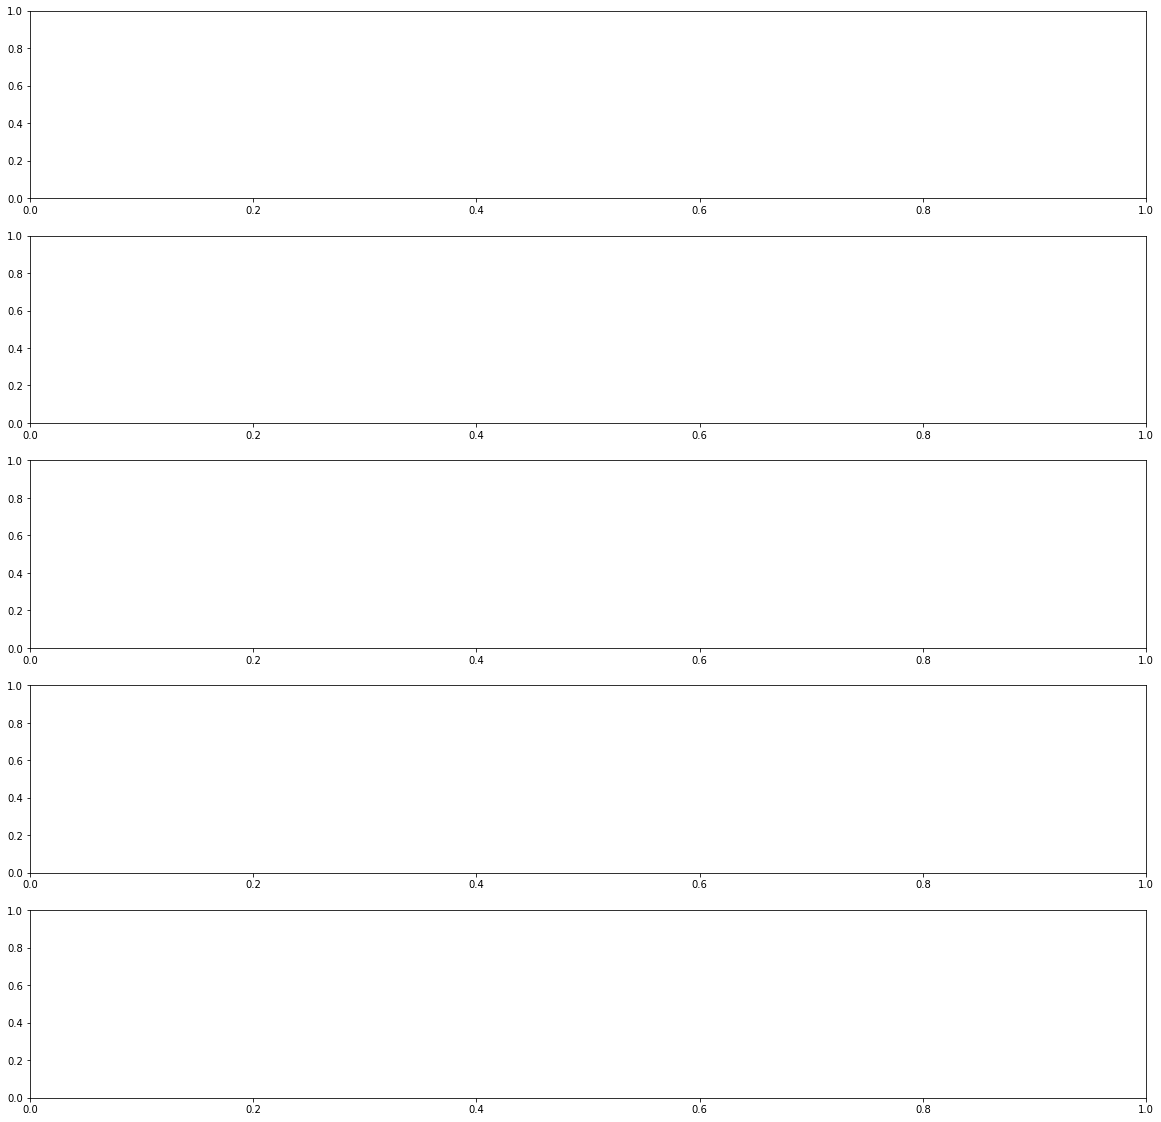

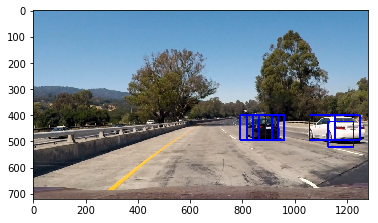

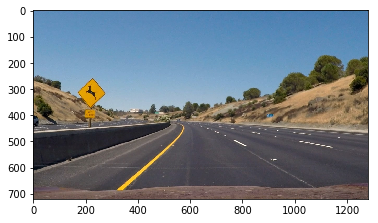

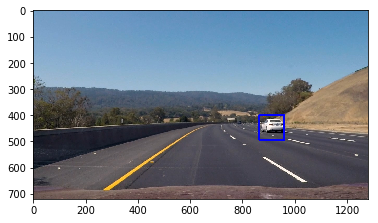

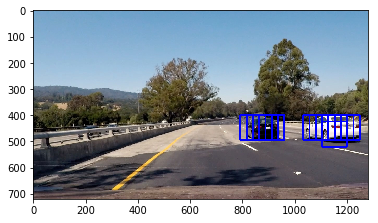

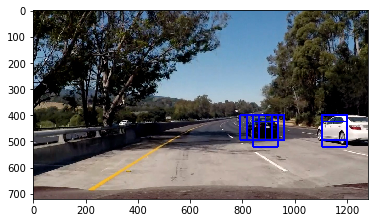

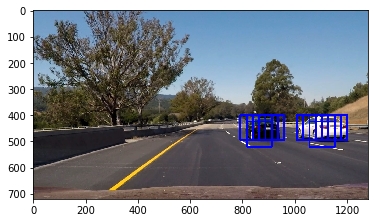

In [87]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = get_image_in_cspace(img_tosearch, colorspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(hog_features).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
    
#find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
fig, axs = plt.subplots(figsize=(20, 20), nrows=5, ncols=1)
axs = axs.ravel()

for file in ['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']:
    out_img = find_cars(get_image('./test_images/'+file), 400, 656, 1.5, svc, X_scaler, "YUV", 9, 8, 2, None, None)
    plt.figure()
    plt.imshow(out_img)